In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

print("Path to dataset files:", path)

100%|██████████| 262M/262M [00:02<00:00, 92.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/austinreese/craigslist-carstrucks-data/versions/10


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(path + '/vehicles.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


# **Data Cleaning**

In [ ]:
df.shape

(426880, 26)

In [21]:
# Drop irrelevant columns
columns_to_drop = ['url', 'region_url', 'VIN', 'description', 'image_url', 'county']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [22]:
# Handle missing values
missing_value_threshold = 0.5
columns_to_keep = df.columns[df.isnull().mean() < missing_value_threshold]
df = df[columns_to_keep]

In [23]:
# Fill missing values for categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [24]:
# Fill missing values for numerical columns with median
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [25]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [27]:
# Remove outliers
price_upper_limit = df['price'].quantile(0.99)
price_lower_limit = 500
df = df[(df['price'] >= price_lower_limit) & (df['price'] <= price_upper_limit)]
odometer_upper_limit = df['odometer'].quantile(0.99)
df = df[df['odometer'] <= odometer_upper_limit]

In [28]:
# Standardize categorical data
categorical_cols = ['condition', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for col in categorical_cols:
    df[col] = df[col].str.lower().str.strip()

In [36]:
# Create new derived columns
df['vehicle_age'] = 2024 - df['year']
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# Adjust format if needed
df['posting_year'] = df['posting_date'].dt.year

# **EDA Section**

In [35]:
# Summary statistics
print(df.describe())
print(df.info())

                 id          price           year       odometer  \
count  3.729470e+05  372947.000000  372947.000000  372947.000000   
mean   7.311461e+09   18245.468345    2010.993356   92291.559219   
min    7.207408e+09     500.000000    1900.000000       0.000000   
25%    7.308073e+09    7636.000000    2008.000000   39631.000000   
50%    7.312573e+09   15500.000000    2013.000000   87985.000000   
75%    7.315242e+09   26995.000000    2017.000000  135000.000000   
max    7.317101e+09   57875.000000    2022.000000  279700.000000   
std    4.480929e+06   12624.824934       9.407741   60772.166133   

                 lat           long posting_date    vehicle_age  posting_year  
count  372947.000000  372947.000000            0  372947.000000           0.0  
mean       38.514123     -94.063815          NaT      13.006644           NaN  
min       -81.838232    -159.719900          NaT       2.000000           NaN  
25%        34.801450    -108.539000          NaT       7.000000    

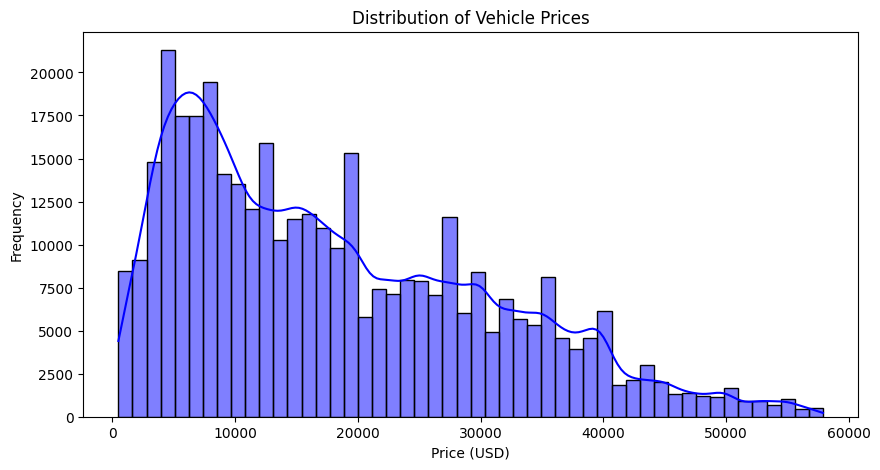

In [37]:
# Distribution of price
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True, bins=50, color='blue')
plt.title('Distribution of Vehicle Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

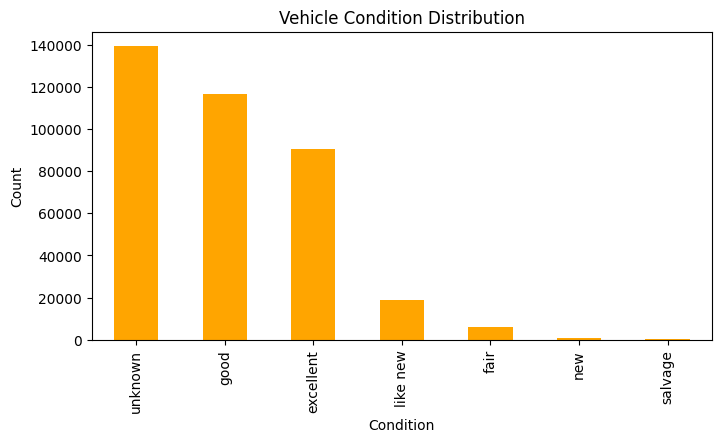

In [38]:
# Vehicle condition counts
plt.figure(figsize=(8, 4))
df['condition'].value_counts().plot(kind='bar', color='orange')
plt.title('Vehicle Condition Distribution')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

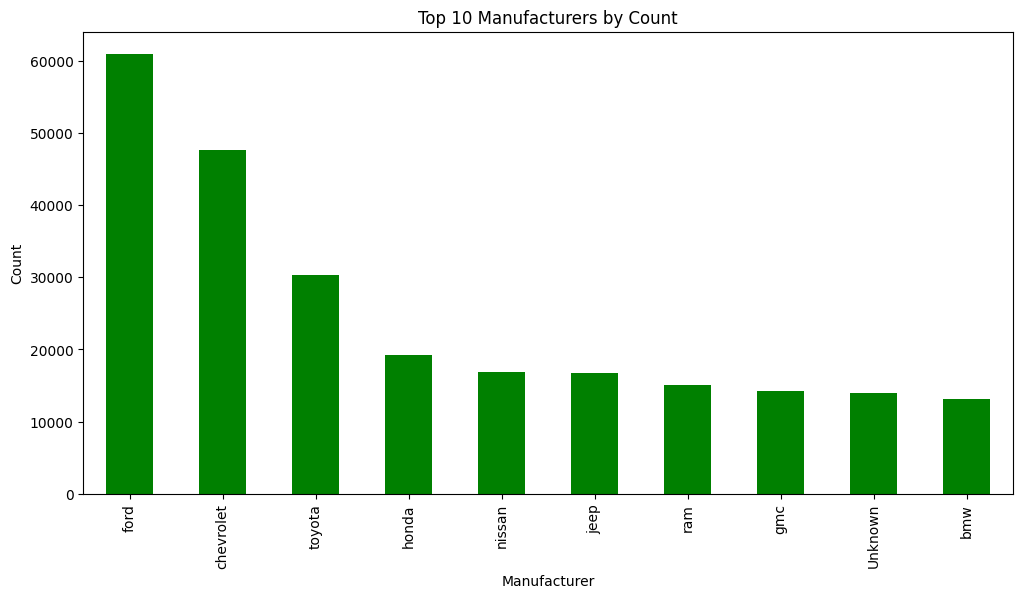

In [39]:
# Manufacturer popularity
plt.figure(figsize=(12, 6))
df['manufacturer'].value_counts().head(10).plot(kind='bar', color='green')
plt.title('Top 10 Manufacturers by Count')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.show()

# **1. What is the price trend for vehicles over time ?**


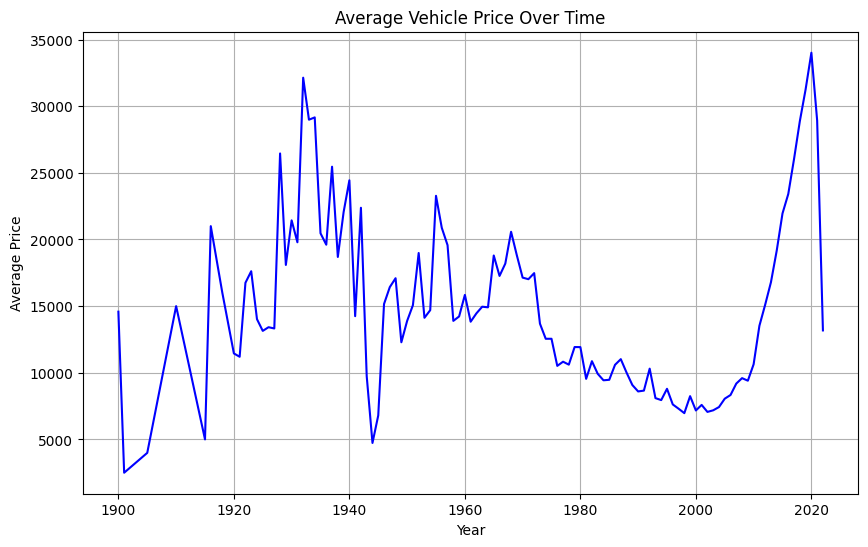

In [48]:
# Average price by year
avg_price_by_year = df.groupby('year')['price'].mean().sort_index()
avg_price_by_year.plot(kind='line', figsize=(10, 6), color='blue')
plt.title('Average Vehicle Price Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid()
plt.show()

# **2. Which vehicle types have the highest average prices?**

In [50]:
# Average price by vehicle type
avg_price_by_type = df.groupby('type')['price'].mean().sort_values(ascending=False)
print(avg_price_by_type)

type
pickup         27309.594237
other          26243.134744
truck          24922.141677
coupe          21282.715383
van            18105.372904
convertible    18051.690688
suv            17528.776219
offroad        15952.849291
hatchback      15256.240131
unknown        14911.644224
bus            14847.939262
wagon          14394.359030
sedan          14384.312071
mini-van        9822.013680
Name: price, dtype: float64


# **3. How does mileage (odometer reading) vary by car condition?**

In [52]:
# Average odometer reading by condition
avg_odometer_by_condition = df.groupby('condition')['odometer'].mean().sort_values()
print(avg_odometer_by_condition)

condition
new           54169.375144
good          75262.714856
like new      82249.377466
unknown       96452.794881
excellent    105870.438411
salvage      131908.391051
fair         153421.765137
Name: odometer, dtype: float64


# **4. How does the price vary across vehicle types?**

In [53]:
# Average price by vehicle type
avg_price_by_type = df.groupby('type')['price'].mean().sort_values(ascending=False)
print(avg_price_by_type)

type
pickup         27309.594237
other          26243.134744
truck          24922.141677
coupe          21282.715383
van            18105.372904
convertible    18051.690688
suv            17528.776219
offroad        15952.849291
hatchback      15256.240131
unknown        14911.644224
bus            14847.939262
wagon          14394.359030
sedan          14384.312071
mini-van        9822.013680
Name: price, dtype: float64


# **5. Which regions or states have the most vehicle listings?**

In [55]:
# Count listings by state
listings_by_state = df['state'].value_counts()
print(listings_by_state)

state
ca    42534
fl    25173
tx    20127
ny    17263
oh    16114
mi    15864
pa    12562
nc    12266
or    12207
wa    10907
wi    10814
tn    10216
co    10017
il     9272
nj     9033
va     8582
ia     7900
az     7775
ma     7524
id     7488
mn     7075
ga     6110
ks     5762
mt     5686
sc     5497
ok     5366
in     5316
ct     4903
al     4567
md     4224
ky     3984
mo     3778
nm     3562
ak     3322
ar     3114
nv     2886
nh     2655
la     2622
dc     2617
hi     2458
me     2388
vt     2307
ri     2236
sd     1189
ut     1021
ne      980
wv      974
ms      928
de      862
wy      548
nd      372
Name: count, dtype: int64


# **6. What is the average price for vehicles based on their condition?**

In [56]:
# Average price by condition
avg_price_by_condition = df.groupby('condition')['price'].mean().sort_values()
print(avg_price_by_condition)

condition
fair          3887.294434
salvage       4070.295720
excellent    14959.992781
like new     17771.648559
unknown      18862.076071
good         20932.669032
new          22316.737629
Name: price, dtype: float64


# **7. What are the most popular vehicle types?**

In [57]:
# Count vehicle types
popular_vehicle_types = df['type'].value_counts()
print(popular_vehicle_types)

type
unknown        79907
sedan          77476
suv            67624
pickup         39146
truck          27351
other          18910
coupe          17188
hatchback      15579
wagon           9729
van             7573
convertible     6980
mini-van        4459
offroad          564
bus              461
Name: count, dtype: int64


# **8. What is the price difference between manual and automatic vehicles?**

In [58]:
# Average price by transmission type
avg_price_by_transmission = df.groupby('transmission')['price'].mean()
print(avg_price_by_transmission)

transmission
automatic    16509.266338
manual       13686.645748
other        28191.625728
unknown      18230.873134
Name: price, dtype: float64


# **9. What are the most common car manufacturers in the dataset?**

In [59]:
# Top 10 manufacturers by count
top_manufacturers = df['manufacturer'].value_counts().head(10)
print(top_manufacturers)

manufacturer
ford         60970
chevrolet    47622
toyota       30361
honda        19227
nissan       16888
jeep         16664
ram          15056
gmc          14232
Unknown      14008
bmw          13146
Name: count, dtype: int64


# **10. Which states have the highest average vehicle price?**

In [61]:
# Average price by state
avg_price_by_state = df.groupby('state')['price'].mean().sort_values(ascending=False)
print(avg_price_by_state.head(10))

state
wv    24394.821355
ak    23051.547261
mt    23023.180795
mo    22161.708841
wa    21949.009260
wy    21553.096715
ar    21254.629737
ut    21199.427032
hi    21077.475590
al    20813.456974
Name: price, dtype: float64
